In [1]:
import data
import data_hf
from modelling import model
import jax.numpy as jnp
import jax
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
np.set_printoptions(edgeitems=30, linewidth=100000, 
    formatter=dict(float=lambda x: "%.3g" % x))

from importlib import reload
from tqdm import tqdm
model = reload(model)
import data
import data_hf
data = reload(data)
data_hf = reload(data_hf)
import data_shae
data_shae = reload(data_shae)
import finetune
finetune = reload(finetune)
import download_data
download_data = reload(download_data)

import numpy as np
import pandas as pd
import umap
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.preprocessing import LabelEncoder
from google.cloud import storage

2024-12-10 23:57:56.613373: I external/local_xla/xla/tsl/cuda/cudart_stub.cc:32] Could not find cuda drivers on your machine, GPU will not be used.
2024-12-10 23:57:56.620046: I external/local_xla/xla/tsl/cuda/cudart_stub.cc:32] Could not find cuda drivers on your machine, GPU will not be used.
2024-12-10 23:57:56.645993: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:485] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
2024-12-10 23:57:56.688882: E external/local_xla/xla/stream_executor/cuda/cuda_dnn.cc:8454] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
2024-12-10 23:57:56.701866: E external/local_xla/xla/stream_executor/cuda/cuda_blas.cc:1452] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
2024-12-10 23:57:56.731123: I tensorflow/core/platform/cpu_feature_gu

In [2]:
cfg = model.Config(
    d_model=2048,
    ffw_multiplier=4,
    query_heads=8,
    key_heads=8,
    num_layers=12,
    key_dim=128,
    vocab_size=8,
    max_seq_len=8192,
    causal=True,
    use_attn_kernel=True,
    weight_dtype_at_rest=jnp.float32,
    active_weight_dtype=jnp.bfloat16,
    rules=model.fsdp_rules,
    mesh=model.create_mesh(),
    max_lr=3e-5,
    min_lr=3e-6,
    warmup_steps=50,
    total_steps=100000,
    return_sae_intermediates=True,
)

# Checkpoint manager setup
checkpoint_dir = "gs://minformer_data/pretrained_ckpt/v1"
ckpt_manager = model.make_mngr(path=checkpoint_dir)

weights, opt_state = model.load(ckpt_manager, cfg)
start_step = ckpt_manager.latest_step()

I1210 23:58:20.383627 3430393 google_auth_provider.cc:181] Running on GCE, using service account 940527310713-compute@developer.gserviceaccount.com


In [3]:
# Set batch size for processing
batch_size = 16

# Define data file pattern for loading
stage_2 = [ "gs://minformer_data/diverse_genomes_tf/human_genome_8192bp_bins_no_N/tfrecords/record_*.tfrecord"]

# Create data iterator
iter = data_shae.create_iterator(
    stage_1=[], stage_2=stage_2, batch_size=batch_size, shuffle=True
)

# Set the batch processing function
process_batch = model.process_batch_shae
# This function will handle converting raw data into model inputs

In [4]:
# Get one example from each
shae_example = next(iter)
print("SHAE keys:", shae_example.keys())
print("SHAE shapes:", {k: v.shape for k,v in shae_example.items()})

Found 0 files for stage 1
Found 2796 files for stage 2
SHAE keys: dict_keys(['x', 'segment_ids', 'lad_category', 'lad_value', 'sad_category', 'sad_value', 'chromosome', 'lad_conserved', 'sad_conserved', 'cell_type', 'start_pos', 'end_pos'])
SHAE shapes: {'x': (16, 8192), 'segment_ids': (16, 8192), 'lad_category': (16, 1), 'lad_value': (16, 1), 'sad_category': (16, 1), 'sad_value': (16, 1), 'chromosome': (1, 16), 'lad_conserved': (16, 1), 'sad_conserved': (16, 1), 'cell_type': (16, 1), 'start_pos': (16, 1), 'end_pos': (16, 1)}


In [4]:
batch = next(iter) # Get the next batch from the iterator

Found 0 files for stage 1
Found 2796 files for stage 2


In [5]:
# This code runs sequences through the model
# Extracts the final hidden states at the last non-padding position

from functools import partial

def fwd(weights, x, segment_ids):
    # Run model forward pass
    _, internals, x = model.forward(x, segment_ids, weights, cfg)

    # Find the last non-padding position in each sequence
    last_nonzero = jnp.sum(segment_ids > 0, axis=-1)

    # Create indices for gathering the final states
    indices = last_nonzero[:, None, None] - 1

    # Extract the final non-padding state for each sequence
    last_xs = jnp.take_along_axis(x, indices, 1)

    return last_xs, internals

def input_shardings(
    mesh, rules
) -> tuple[jax.sharding.NamedSharding, jax.sharding.NamedSharding, jax.sharding.NamedSharding]:
    logical_axes = {
        "x": model.P("batch", "sequence"),
        "segment_ids": model.P("batch", "sequence"),
    }
    physical_axes = jax.tree.map(partial(model._logical_to_sharding, mesh=mesh, rules=rules), logical_axes)
    return physical_axes


fwd = jax.jit(fwd) # Compile the forward function for faster execution

In [6]:
jax.random.PRNGKey # Random number generation

<function jax._src.random.PRNGKey(seed: 'int | ArrayLike', *, impl: 'PRNGSpecDesc | None' = None) -> 'KeyArray'>

In [7]:
#!pip install wandb
import wandb
wandb.init(project="sae-test", name="sae-l17e-9v2")

wandb: Using wandb-core as the SDK backend.  Please refer to https://wandb.me/wandb-core for more information.
wandb: Currently logged in as: shae-mclaughlin (cellware). Use `wandb login --relogin` to force relogin


In [8]:
# Make an SAE
features = 8192 # Number of features in expanded representation 

# Initialize encoder and decoder weights
expand = jax.nn.initializers.he_normal(in_axis=0, out_axis=1)(jax.random.PRNGKey(0), (cfg.d_model, features), jnp.float32)
contract = jax.nn.initializers.he_normal(in_axis=0, out_axis=1)(jax.random.PRNGKey(1), (features, cfg.d_model), jnp.float32)
l1_coeff = 7e-9 # L1 sparsity coefficient 
lr = 3e-4 # Learning rate

# Define weight structure
sae_weights = {
    'expand': expand, # Encoder weights
    'contract': contract, # Decoder weights
}

def sae_shardings(
    mesh, rules
) -> tuple[jax.sharding.NamedSharding, jax.sharding.NamedSharding, jax.sharding.NamedSharding]:
    logical_axes = {
        "expand": model.P("batch", "ffw"),
        "contract": model.P("ffw", "batch"),
    }
    physical_axes = jax.tree.map(partial(model._logical_to_sharding, mesh=mesh, rules=rules), logical_axes)
    return physical_axes

sae_weights = jax.device_put(sae_weights, sae_shardings(cfg.mesh, cfg.rules))
sae_opt_state = model.init_optimizer_state(sae_weights)

def fwd_sae(sae_weights,
            activations, # [B, T, D]
            ):
    # Reshape batch of activations to 2D
    activations = activations.reshape(-1, cfg.d_model) # [B*T, D]
    
    # Encode: expand to larger sparse representation
    latents = jnp.einsum('bd,df->bf', activations, sae_weights['expand'])
    latents = jax.nn.relu(latents) # Apply ReLU activation
    
    # Decode: reconstruct original activations
    reconstructed = jnp.einsum('bf,fd->bd', latents, sae_weights['contract'])
    
    # Losses
    reconstruction_loss = jnp.mean((reconstructed-activations)**2) # MSE
    l1_loss = l1_coeff * jnp.sum(latents) # L1 sparsity penalty
    loss = reconstruction_loss + l1_loss
    return loss, {'latents': latents, 'reconstruction_loss': reconstruction_loss, 'l1_loss': l1_loss, 'nonzero_fraction': jnp.mean(latents > 0)}

grad_sae = jax.value_and_grad(fwd_sae)

def update_weights_sae(weights,
                       opt_state,
                       activations,
                       step):
    # Compute loss and gradients
    (loss, internals), grads = jax.value_and_grad(fwd_sae, has_aux=True)(weights, activations)
    # Update weights using Adam
    weights, opt_state, _ = model.update_weights(weights, grads, opt_state, lr, step, cfg, {})
    return weights, opt_state, loss, internals

update_weights_fn = jax.jit(update_weights_sae)

In [9]:
# Create checkpoint manager before training loop
sae_ckpt_manager = model.make_mngr(path="gs://minformer_data/sae_ckpt/v9")

# Training loop
step = 0

for batch in iter:
    batch = jax.device_put({'x': batch['x'], 'segment_ids': batch['segment_ids']}, input_shardings(cfg.mesh, cfg.rules))
    _, internals = fwd(weights, batch['x'], batch['segment_ids'])
    activations = internals['layer_6_activations']
    sae_weights, sae_opt_state, loss, internals = update_weights_fn(sae_weights, sae_opt_state, activations, step=1)
    
    # Get latents and normalize them
    latents = internals['latents']
    latents_normalized = (latents - jnp.min(latents)) / (jnp.max(latents) - jnp.min(latents))
    sparsity_80 = jnp.sum(latents_normalized > 0.8)
    sparsity_50 = jnp.sum(latents_normalized > 0.5)
    sparsity_30 = jnp.sum(latents_normalized > 0.3)
    sparsity_10 = jnp.sum(latents_normalized > 0.1)
    sparsity_any = jnp.mean(latents > 0)
    
    # Get max activation of each feature across all positions
    max_per_feature = jnp.max(latents_normalized, axis=0)
    
    # Count features that exceed different thresholds
    strong_features_80 = jnp.sum(max_per_feature > 0.8)
    strong_features_50 = jnp.sum(max_per_feature > 0.5)
    strong_features_30 = jnp.sum(max_per_feature > 0.3)
    strong_features_10 = jnp.sum(max_per_feature > 0.1)

    # Log metrics to wandb
    wandb.log({
        "reconstruction_loss": internals['reconstruction_loss'],
        "l1_loss": internals['l1_loss'],
        "total_loss": internals['reconstruction_loss'] + internals['l1_loss'],
        "step": step,
        "sparsity_80": float(sparsity_80),
        "sparsity_50": float(sparsity_50),
        "sparsity_30": float(sparsity_30),
        "sparsity_10": float(sparsity_10),
        "sparsity_raw": float(sparsity_any),
        "max_activation": float(jnp.max(latents)),
        "mean_activation": float(jnp.mean(latents)),
        "activation_std": float(jnp.std(latents)),
        "unique_features_80": float(strong_features_80),  # how many of 8192 features ever exceed 0.8
        "unique_features_50": float(strong_features_50),
        "unique_features_30": float(strong_features_30),
        "unique_features_10": float(strong_features_10)
    })

    # Save checkpoint periodically (e.g., every 1000 steps)
    if step > 0 and step % 1000 == 0:
        print(f"Saving checkpoint at step {step}")
        model.save(sae_ckpt_manager, sae_weights, sae_opt_state, step)
    step += 1

Saving checkpoint at step 1000
Saving checkpoint at step 2000
Saving checkpoint at step 3000
Saving checkpoint at step 4000
Saving checkpoint at step 5000
Saving checkpoint at step 6000
Saving checkpoint at step 7000
Saving checkpoint at step 8000
Saving checkpoint at step 9000
Saving checkpoint at step 10000
Saving checkpoint at step 11000
Saving checkpoint at step 12000
Saving checkpoint at step 13000
Saving checkpoint at step 14000
Saving checkpoint at step 15000
Saving checkpoint at step 16000
Saving checkpoint at step 17000
Saving checkpoint at step 18000
Saving checkpoint at step 19000
Saving checkpoint at step 20000
Saving checkpoint at step 21000
Saving checkpoint at step 22000


2024-12-11 03:27:15.883296: I tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence


In [38]:
def detokenize_sequence(seq):
    """Convert tokenized sequence to DNA bases"""
    token_map = {2: 'A', 3: 'C', 4: 'G', 5: 'T'}
    return ''.join(token_map.get(int(x), 'N') for x in seq)

# Create new iterator
iter = data_shae.create_iterator(
    stage_1=[], 
    stage_2=["gs://minformer_data/diverse_genomes_tf/human_genome_8192bp_bins_no_N/tfrecords/record_*.tfrecord"], 
    batch_size=batch_size, 
    shuffle=True
)

# Get a batch and run it through the model and SAE
batch = next(iter)
batch = jax.device_put({'x': batch['x'], 'segment_ids': batch['segment_ids']}, input_shardings(cfg.mesh, cfg.rules))
_, internals = fwd(weights, batch['x'], batch['segment_ids'])
activations = internals['layer_6_activations']

# Run through SAE encoder
activations = activations.reshape(-1, cfg.d_model)
latents = jnp.einsum('bd,df->bf', activations, sae_weights['expand'])
latents = jax.nn.relu(latents)
latents_np = np.array(latents)

# Get max activation per feature
max_activations_per_feature = np.max(latents_np, axis=0)

# Create DataFrame with feature stats
feature_stats = pd.DataFrame({
    'feature_id': np.arange(len(max_activations_per_feature)),
    'max_activation': max_activations_per_feature,
})

# Sort by max activation
feature_stats = feature_stats.sort_values('max_activation', ascending=False)

# Add context sequences for top activations
top_features = []
for feature_id in feature_stats.head(100)['feature_id']:
    # Find positions where this feature strongly activates
    feature_activations = latents_np[:, feature_id]
    strong_positions = np.where(feature_activations > 0.8 * np.max(feature_activations))[0]
    
    if len(strong_positions) > 0:
        # Get a few example sequences
        for pos in strong_positions[:5]:  # Get up to 3 examples
            batch_idx = pos // 8192
            seq_pos = pos % 8192
            
            # Get sequence context
            sequence = batch['x'][batch_idx]
            start = max(0, seq_pos - 15)
            end = min(len(sequence), seq_pos + 15)
            context = sequence[start:end]
            
            top_features.append({
                'feature_id': feature_id,
                'activation': feature_activations[pos],
                'sequence': detokenize_sequence(context),
                'batch_idx': batch_idx,
                'position': seq_pos
            })

# Create DataFrame with detailed feature information
detailed_features = pd.DataFrame(top_features)

# Save to CSV files
feature_stats.to_csv('feature_stats.csv', index=False)
detailed_features.to_csv('detailed_features.csv', index=False)

# Print summary
print("\nTop 20 features by maximum activation:")
print(feature_stats.head(30))

print("\nExample sequences for top 5 features:")
for feature_id in feature_stats.head(10)['feature_id']:
    examples = detailed_features[detailed_features['feature_id'] == feature_id]
    print(f"\nFeature {feature_id} (max activation: {feature_stats.loc[feature_stats['feature_id'] == feature_id, 'max_activation'].iloc[0]:.2f})")
    for _, row in examples.iterrows():
        print(f"Activation {row['activation']:.2f}: {row['sequence']}")

Found 0 files for stage 1
Found 2796 files for stage 2

Top 20 features by maximum activation:
      feature_id  max_activation
3422        3422       26.390961
5959        5959       24.997349
1685        1685       24.521923
5633        5633       24.190645
303          303       23.876350
2053        2053       23.870953
1947        1947       23.666672
4893        4893       23.619648
3990        3990       23.324368
2159        2159       23.294113
7845        7845       23.253981
6443        6443       23.201954
6702        6702       23.063057
8167        8167       22.882771
5532        5532       22.878641
3779        3779       22.697948
4862        4862       22.633593
3828        3828       22.623320
152          152       22.599157
6428        6428       22.554914
1900        1900       22.525883
7837        7837       22.514065
1339        1339       22.456919
1393        1393       22.383209
2869        2869       22.054190
3346        3346       21.988052
3181        31

In [50]:
import matplotlib.pyplot as plt
import numpy as np
from collections import Counter

def get_conservation(sequences):
    """Return conservation level for each position"""
    seq_length = len(sequences[0])
    conservation = []
    
    for pos in range(seq_length):
        # Get all nucleotides at this position
        nucleotides = [seq[pos] for seq in sequences]
        unique_nucleotides = len(set(nucleotides))
        
        if unique_nucleotides == 1:
            conservation.append('highly_conserved')  # Orange
        elif unique_nucleotides == 2:
            conservation.append('partially_conserved')  # Light orange
        else:
            conservation.append('not_conserved')  # No highlight
    
    return conservation

def plot_sequences(sequences, activations, feature_id="3990", title="Feature Recognition Pattern"):
    fig, ax = plt.subplots(figsize=(12, 4))
    
    # Define highlight colors
    colors = {
        'highly_conserved': '#FFB74D',    # Orange
        'partially_conserved': '#FFE0B2',  # Light orange
        'not_conserved': 'none'           # No highlight
    }
    
    # Get conservation pattern
    conservation = get_conservation(sequences)
    
    # For each sequence
    for i, (seq, act) in enumerate(zip(sequences, activations)):
        y_pos = len(sequences) - i - 1
        
        # Add activation value
        ax.text(-2, y_pos, f"{act:.2f}", va='center', ha='right', fontsize=10, fontfamily='monospace')
        
        # Add sequence with highlighting
        for j, char in enumerate(seq):
            # Draw highlight rectangle based on conservation
            ax.add_patch(plt.Rectangle((j-0.2, y_pos-0.4), 0.4, 0.8, 
                                    facecolor=colors[conservation[j]], 
                                    edgecolor='none'))
            
            # Draw the character
            ax.text(j, y_pos, char, 
                   color='black',
                   fontsize=12, 
                   fontfamily='monospace',
                   ha='center', 
                   va='center',
                   fontweight='bold')
    
    ax.set_title(f"Feature {feature_id}: {title}", pad=20)
    ax.set_xlim(-3, len(sequences[0]) + 1)
    ax.set_ylim(-1, len(sequences))
    ax.axis('off')
    
    plt.tight_layout()
    return fig

# Test with your sequences
sequences = [
   "CTCTACTAAAAATACAAAAATTAGCTGGGC",
   "CTCTACTAAAAATACAAAAAATTAGCCGGG",
   "CTCTACTAAAAATACAAAATTAGCCGGGCA",
   "CTGTACCAAAAATACAAAAATTAGCTGGGT",
   "CTCTACTAAAAATACAAAAAAATTAGCCTG"
]

activations = [21.81, 23.32, 21.43, 18.81, 18.79]

fig = plot_sequences(sequences, activations)
plt.savefig('feature_3990_conservation.png', dpi=300, bbox_inches='tight')
plt.close()

In [49]:
import logomaker
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

def create_sequence_logo(sequences, title):
   # Convert sequences to a count matrix
   counts_mat = logomaker.alignment_to_matrix(sequences)
   
   # Create Logo object
   fig, ax = plt.subplots(figsize=(15, 3))
   logo = logomaker.Logo(counts_mat,
                        ax=ax,
                        fade_below=0.7,
                        shade_below=0.5,
                        font_name='Arial')
   
   # Style using Logo methods
   logo.style_spines(visible=False)
   logo.style_xticks(rotation=0, fmt='%d', anchor=0)
   plt.title(f'Sequence Logo for Feature {title}')
   
   return fig

# Feature sequences
feature_sequences = {
   '3422': [
       "CAAAGTGCTGGGATTACAAGCGTGAGCCAC",
       "CAAGGTGCTGGGATTACATGTGTGAGCCAC",
       "CAAAGTGCTAGGATTACAGGAATGAATCAC",
       "CAAAGTGTTGGGATTACAGGTGTGAGCCAC",
       "CAAAGTGCTGGGATTATAGGCGTGAGCTGC"
   ],
   '5633': [
       "TCAGCCTCCTGAGTAGCGGGGATTACAGGT",
       "TCAGCCTCCCGAGTAGCTGGAATTACAGGC",
       "CAGCCTCTCCGAGTAGCTGGGACTACAGGC",
       "TCAGCCTCCCAAGTAGCTGGGACTACAGGT",
       "TCAGCCTCCTGAGTAGCTGGGCTTACAGTT"
   ],
   '5959': [
       "TGTAATCCCAGCTACTTGGGAGGCTGTGGC",
       "TGTAATCTCAGCTACTCAGGAGGCTGAGGC",
       "TGTAGTCCCAGCTACTCGGGAGGCTGAGGC",
       "TGTAATCCCAGCTACTCAGGAGGGTAAGGC",
       "TGTAATCCCAGCTACTTGGGAGGCTGAGGC"
   ],
   '3990': [
       "CTCTACTAAAAATACAAAAATTAGCTGGGC",
       "CTCTACTAAAAATACAAAAAATTAGCCGGG",
       "CTCTACTAAAAATACAAAATTAGCCGGGCA",
       "CTGTACCAAAAATACAAAAATTAGCTGGGT",
       "CTCTACTAAAAATACAAAAAAATTAGCCTG"
   ],
   '1685': [
       "CCCAGCTACTTGGGAGGCTGTGGCAGGAGA",
       "CTCAGCTACTCAGGAGGCTGAGGCAGGAGA",
       "CCCAGCTACTCGGGAGGCTGAGGCAGGAGA",
       "CCCAGCTACTCAGGAGGGTAAGGCAGGAGA",
       "CCCAGCTACTTGGGAGGCTGAGGCAGGAGA"
   ]
}

# Create and save logos for each feature
for feature_id, sequences in feature_sequences.items():
   fig = create_sequence_logo(sequences, feature_id)
   plt.savefig(f'feature_{feature_id}_logo.png', dpi=300, bbox_inches='tight')
   plt.close()

In [11]:
import pandas as pd
import numpy as np

# Load genome data
genome_df = pd.read_csv("gs://minformer_data/eukaryote_pands/human_genome_8192bp_bins_no_N.csv")

print(genome_df)

       Chrom     Start       End  \
0       chr1     16385     24576   
1       chr1     24577     32768   
2       chr1     32769     40960   
3       chr1     40961     49152   
4       chr1     49153     57344   
...      ...       ...       ...   
357928  chrY  57171969  57180160   
357929  chrY  57180161  57188352   
357930  chrY  57188353  57196544   
357931  chrY  57196545  57204736   
357932  chrY  57204737  57212928   

                                                 Sequence  Contains_N  
0       CCCAGAGCCTCACTTGTTCAGGCTCCCTCTGCCCTAGAAGTGAGAA...       False  
1       CCAAGTTGGGCTCTCACTTCAGCCCCTCCCACACAGGGAAGCCAGA...       False  
2       ATTTGAAGCTTCACCAGACAGACCAGACAGCTTAGCCCTCGTGTTG...       False  
3       TTTTCTATATTCAAAGAAAAGTCCTCAGCCAGAGATTCTCAGGAGC...       False  
4       CACCGTGGATTACTATGCAGCCATAAAAAAGAACAAGATCATGTCT...       False  
...                                                   ...         ...  
357928  TGGACCCGGCACCAGATTGAAAGGAACAGGAAGTGCTCTCCCCCTC...      

In [33]:
import logomaker
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

def create_sequence_logo(sequences, title):
    # Convert sequences to a count matrix
    counts_mat = logomaker.alignment_to_matrix(sequences)
    
    # Create Logo object
    fig, ax = plt.subplots(figsize=(12, 3))
    logo = logomaker.Logo(counts_mat,
                         ax=ax,
                         fade_below=0.7,
                         shade_below=0.5,
                         font_name='Arial')
    
    # Style using Logo methods
    logo.style_spines(visible=False)
    logo.style_xticks(rotation=0, fmt='%d', anchor=0)
    plt.title(f'Sequence Logo for Feature {title}')
    
    return fig

# Feature sequences
feature_sequences = {
    '3422': [
        "TGCTGAGATTACAGGCATGAG",
        "TGCTGGGATTACAAGTGTGAG",
        "TGCTGGGATTACAGGCGTGAG"
    ],
    '5959': [
        "TCCTAGCTACTCGAGAGGCTG",
        "TTCTAGCTACTCAGGAAGCTG",
        "TCCCAGCTACTCAAGAGGCTG"
    ],
    '2053': [
        "GCACTCCAGCCTGGGTGACAG",
        "GCACTCCAGCCTGGGTGACAG",
        "GCACTCCAGCCTGGGCAACAG"
    ],
    '5208': [
        "TGGGAAAACTGGCTAGCCATA",
        "TGGGAAAACTGGCTAGCCATA",
        "TGGGATAACTGGCTAGCCATA"
    ],
    '303': [
        "GGCATGAGCCACCACATCCAG",
        "AGTGTGAGCCACCGCGCCTGG",
        "GGCGTGAGCCACCGCGCCCGG"
    ]
}

# Create and save logos for each feature
for feature_id, sequences in feature_sequences.items():
    fig = create_sequence_logo(sequences, feature_id)
    plt.savefig(f'feature_{feature_id}_logo.png', dpi=300, bbox_inches='tight')
    plt.close()

In [59]:
import pandas as pd
import numpy as np
from tqdm import tqdm

# Pick a feature to track from our top activating ones
feature_to_track = 3990  # Example feature
activation_threshold = 5

# Function to convert sequence string to token array
def tokenize_sequence(seq):
    token_map = {'A': 2, 'C': 3, 'G': 4, 'T': 5}
    return np.array([token_map[base] for base in seq])

# Process just one chunk
chunk_size = 16  # Match our batch size
bedgraph_path = f'feature_{feature_to_track}.bedgraph'

# Read just first chunk
chunk = next(pd.read_csv("gs://minformer_data/eukaryote_pands/human_genome_8192bp_bins_no_N.csv", 
                        chunksize=chunk_size))

# Open bedGraph file to write results
with open(bedgraph_path, 'w') as f:
    # Write header exactly like the working example
    f.write('track type=bedGraph name="Feature {} Activations" description="SAE Feature Activations" visibility=full color=200,0,0\n'.format(feature_to_track))
    
    # Convert sequences to token arrays
    sequences = np.stack([tokenize_sequence(seq) for seq in chunk['Sequence']])
    
    # Create batch
    batch = {
        'x': sequences,
        'segment_ids': np.ones_like(sequences)
    }
    
    # Get activations
    batch = jax.device_put(batch, input_shardings(cfg.mesh, cfg.rules))
    _, internals = fwd(weights, batch['x'], batch['segment_ids'])
    activations = internals['layer_6_activations']
    
    # Get feature activations through SAE
    activations = activations.reshape(-1, cfg.d_model)
    latents = jnp.einsum('bd,df->bf', activations, sae_weights['expand'])
    latents = jax.nn.relu(latents)
    
    # Extract activations for our feature
    feature_activations = latents[:, feature_to_track]
    
    # Write to bedGraph
    for i, row in chunk.iterrows():
        chr_name = row['Chrom']
        start_pos = row['Start']
        for pos, activation in enumerate(feature_activations[i*8192:(i+1)*8192]):
            if activation > activation_threshold:  # Only write non-zero activations to save space
                curr_pos = start_pos + pos
                f.write(f'{chr_name}\t{curr_pos}\t{curr_pos + 1}\t{activation:.8f}\n')

print(f"Created bedGraph file: {bedgraph_path}")

Created bedGraph file: feature_3990.bedgraph


In [10]:
def analyze_activations(sae_weights, batch):
    # Get activations from transformer and run through SAE
    _, internals = fwd(weights, batch['x'], batch['segment_ids'])
    activations = internals['layer_6_activations']
    
    # Run through SAE encoder only
    activations = activations.reshape(-1, cfg.d_model)
    latents = jnp.einsum('bd,df->bf', activations, sae_weights['expand'])
    latents = jax.nn.relu(latents)
    
    # Convert to numpy for easier analysis
    latents_np = np.array(latents)
    
    # Get distribution stats
    percentiles = np.percentile(latents_np, [0, 25, 50, 75, 90, 95, 99, 100])
    
    print("Activation distribution:")
    print(f"Min (0th): {percentiles[0]:.3f}")
    print(f"25th: {percentiles[1]:.3f}")
    print(f"Median: {percentiles[2]:.3f}")
    print(f"75th: {percentiles[3]:.3f}")
    print(f"90th: {percentiles[4]:.3f}")
    print(f"95th: {percentiles[5]:.3f}")
    print(f"99th: {percentiles[6]:.3f}")
    print(f"Max (100th): {percentiles[7]:.3f}")
    
    # Maybe plot a histogram
    plt.figure(figsize=(10, 6))
    plt.hist(latents_np.flatten(), bins=50)
    plt.title("Distribution of SAE Activations")
    plt.xlabel("Activation Value")
    plt.ylabel("Count")
    plt.yscale('log')  # Log scale might help see the tail
    plt.show()
    
    return latents_np

Activation distribution:
Min (0th): 0.000
25th: 0.000
Median: 0.000
75th: 0.000
90th: 0.454
95th: 0.700
99th: 1.205
Max (100th): 52.792


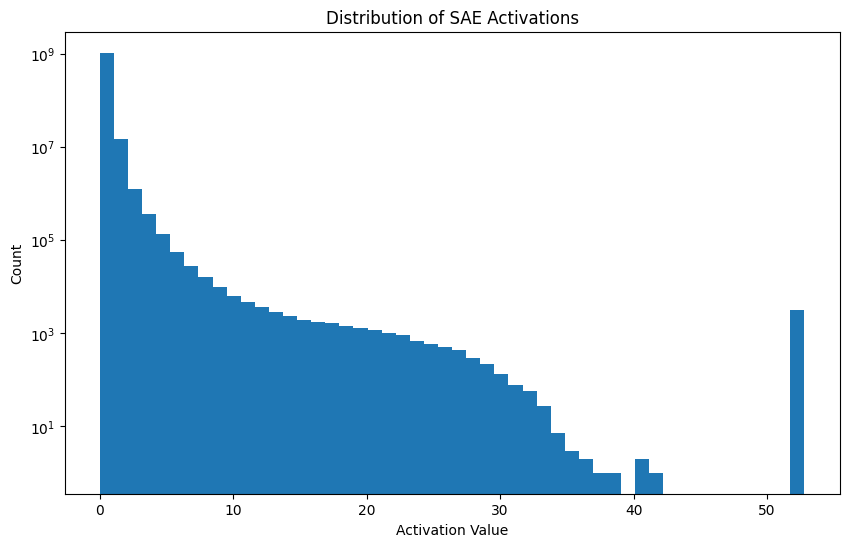

In [12]:
# Get a batch of data
batch = next(iter)  # or however you get your data batches

# Run the analysis
latents = analyze_activations(sae_weights, batch)

In [14]:
# Get data and run SAE forward pass
batch = next(iter)
_, internals = fwd(weights, batch['x'], batch['segment_ids']) 
activations = internals['layer_6_activations']

# Run through SAE encoder
activations = activations.reshape(-1, cfg.d_model)
latents = jnp.einsum('bd,df->bf', activations, sae_weights['expand'])
latents = jax.nn.relu(latents)
latents_np = np.array(latents)

def analyze_activation_ranges(latents_np):
   total = latents_np.size
   
   ranges = [
       (0, 0.001),  # essentially zero  
       (0.001, 1.0),
       (1.0, 5.0),
       (5.0, 10.0),
       (10.0, 20.0),
       (20.0, 30.0),
       (30.0, 40.0),
       (40.0, 50.0),
       (50.0, float('inf'))
   ]
   
   for min_val, max_val in ranges:
       count = np.sum((latents_np >= min_val) & (latents_np < max_val))
       percentage = (count / total) * 100
       print(f"{min_val:5.1f} to {max_val:5.1f}: {count:10d} ({percentage:5.2f}%)")

# Run the analysis
analyze_activation_ranges(latents_np)

  0.0 to   0.0:  828526309 (77.16%)
  0.0 to   1.0:  224989330 (20.95%)
  1.0 to   5.0:   20066026 ( 1.87%)
  5.0 to  10.0:     128940 ( 0.01%)
 10.0 to  20.0:      22986 ( 0.00%)
 20.0 to  30.0:       4921 ( 0.00%)
 30.0 to  40.0:        240 ( 0.00%)
 40.0 to  50.0:          0 ( 0.00%)
 50.0 to   inf:       3072 ( 0.00%)


In [58]:
import matplotlib.pyplot as plt
import numpy as np
from collections import Counter

def get_conservation(sequences):
    """Return conservation level for each position"""
    seq_length = len(sequences[0])
    conservation = []
    
    for pos in range(seq_length):
        nucleotides = [seq[pos] for seq in sequences]
        unique_nucleotides = len(set(nucleotides))
        
        if unique_nucleotides == 1:
            conservation.append('highly_conserved')
        elif unique_nucleotides == 2:
            conservation.append('partially_conserved')
        else:
            conservation.append('not_conserved')
    
    return conservation

def plot_sequences(sequences, activations, feature_id="3422", title="Feature Recognition Pattern"):
    fig, ax = plt.subplots(figsize=(15, 10))  # Made figure larger for 20 sequences
    
    colors = {
        'highly_conserved': '#FFB74D',    
        'partially_conserved': '#FFE0B2',  
        'not_conserved': 'none'           
    }
    
    conservation = get_conservation(sequences)
    
    for i, (seq, act) in enumerate(zip(sequences, activations)):
        y_pos = len(sequences) - i - 1
        
        # Add activation value
        ax.text(-2, y_pos, f"{act:.2f}", va='center', ha='right', fontsize=10, fontfamily='monospace')
        
        # Add sequence with highlighting
        for j, char in enumerate(seq):
            ax.add_patch(plt.Rectangle((j-0.2, y_pos-0.4), 0.4, 0.8, 
                                    facecolor=colors[conservation[j]], 
                                    edgecolor='none'))
            
            ax.text(j, y_pos, char, 
                   color='black',
                   fontsize=12, 
                   fontfamily='monospace',
                   ha='center', 
                   va='center',
                   fontweight='bold')
    
    ax.set_title(f"Feature {feature_id}: {title}", pad=20)
    ax.set_xlim(-3, len(sequences[0]) + 1)
    ax.set_ylim(-1, len(sequences))
    ax.axis('off')
    
    plt.tight_layout()
    return fig

# Feature 3422 sequences and activations
sequences = [
    "CAAAGTGCTGGGATTACAGGCTTGAGCCAC",
    "CAAAGTGCTGGGATTACAGGCGTGAGCCAC",
    "CAAAGTGCTGGGATTACAGGCGTTGAGCCA",
    "CAAAGTGCTGGGATTACAGGTGTGAGCCAT",
    "CAAAGTGCTGGGATTACAGGCGTGAGCTGC",
    "CAAAGTGCTGGGATTACAGGTGTGTGTCAC",
    "CAAAGTGCTGGGATTACAGGCGTGAGCCAC",
    "CAAAGTGCTGGGATTACAGGCATGAGCCAC",
    "CAGAGTGCTGGGATTACAGGCGTGAGCCAC",
    "CATAGTGCTGGGATTACAGGCGTGAGCCAC",
    "CAAAGTGTTGGGATTACAGGCGGGAGCCAC",
    "CAAAGAGCTGGGATTACAGGCATGCCTGCA",
    "CAAAGTGCTGGGATTACAGGTGTGAGCCAC",
    "CAAAGTGCTGAGATTACAGGCAAAAGCCAC",
    "CAAAGTGCTAGGATTATAGGTGTGAGCCAT",
    "CACAGTGTTAGGATTACAGGCGTGAGCCAC",
    "CAAAGTGCTGGGATTACAGGCATGAGCTGC",
    "CGAAGTGCTGGGATTACATGTGTGAGCCTG",
    "CAAAGTGCTGGGATTACAGGTATGAGCCCC",
    "CATAGAGCTGGGATTACAGGTGTGAGCCAC"
]

activations = [25.93, 25.75, 25.45, 25.04, 24.90, 24.81, 24.39, 24.35, 23.74, 23.31, 
               22.79, 22.48, 22.39, 22.30, 22.01, 21.74, 21.09, 21.05, 20.89, 20.43]

# Create and save the visualization
fig = plot_sequences(sequences, activations)
plt.savefig('feature_3422_conservation_full.png', dpi=300, bbox_inches='tight')
plt.close()

In [16]:
# Get a batch and run it through the model and SAE
batch = next(iter)
batch = jax.device_put({'x': batch['x'], 'segment_ids': batch['segment_ids']}, input_shardings(cfg.mesh, cfg.rules))
_, internals = fwd(weights, batch['x'], batch['segment_ids'])
activations = internals['layer_6_activations']

# Run through SAE encoder
activations = activations.reshape(-1, cfg.d_model)
latents = jnp.einsum('bd,df->bf', activations, sae_weights['expand'])
latents = jax.nn.relu(latents)
latents_np = np.array(latents)

# Only look at non-padding positions (before position 8000)
valid_positions = np.arange(len(latents_np)) % 8192 < 8000
latents_valid = latents_np[valid_positions]

# Find top activations
# Get indices sorted by activation strength
flat_indices = np.argsort(latents_valid.flatten())[-100:]  # get top 100 activations
positions = flat_indices // 8192
features = flat_indices % 8192

print("\nTop activations in non-padding regions:")
for i in range(min(20, len(positions))):
    batch_idx = positions[i] // 8000
    seq_pos = positions[i] % 8000
    value = latents_valid.flatten()[flat_indices[i]]
    
    # Get the actual DNA sequence around this position
    sequence = batch['x'][batch_idx]  # Get the full sequence
    # Get context around the position (e.g., 10 bases before and after)
    start = max(0, seq_pos - 10)
    end = min(len(sequence), seq_pos + 11)
    context = sequence[start:end]
    
    print(f"\nBatch {batch_idx}, Position {seq_pos}: Feature {features[i]} activated with value {value:.2f}")
    print(f"Sequence context: {context}")  # This will show the actual DNA sequence if available


Top activations in non-padding regions:

Batch 13, Position 6103: Feature 1532 activated with value 31.07
Sequence context: [3 5 4 4 4 2 5 5 2 3 2 4 4 2 4 5 4 2 4 3 3]

Batch 13, Position 7412: Feature 940 activated with value 31.14
Sequence context: [2 3 2 2 2 2 2 2 5 5 2 4 3 3 2 4 4 3 4 5 4]

Batch 4, Position 6648: Feature 5633 activated with value 31.15
Sequence context: [3 5 4 4 5 2 4 3 5 4 4 4 2 3 5 2 3 2 4 4 3]

Batch 1, Position 6559: Feature 7845 activated with value 31.17
Sequence context: [2 2 4 5 2 4 3 5 4 4 4 2 3 5 2 3 2 4 4 3 4]

Batch 0, Position 2947: Feature 3049 activated with value 31.18
Sequence context: [3 3 3 2 4 3 2 3 5 5 5 4 4 4 2 4 4 3 3 4 2]

Batch 14, Position 6663: Feature 7353 activated with value 31.19
Sequence context: [5 4 2 5 3 2 5 4 4 5 4 4 2 5 2 2 4 3 5 5 5]

Batch 1, Position 6687: Feature 6187 activated with value 31.23
Sequence context: [3 3 5 3 3 3 2 2 2 4 5 4 3 5 4 4 4 2 5 5 2]

Batch 13, Position 7457: Feature 4637 activated with value 31.24
Se

In [57]:
# Get a batch and run it through the model and SAE
batch = next(iter)
batch = jax.device_put({'x': batch['x'], 'segment_ids': batch['segment_ids']}, input_shardings(cfg.mesh, cfg.rules))
_, internals = fwd(weights, batch['x'], batch['segment_ids'])
activations = internals['layer_6_activations']

# Run through SAE encoder
activations = activations.reshape(-1, cfg.d_model)
latents = jnp.einsum('bd,df->bf', activations, sae_weights['expand'])
latents = jax.nn.relu(latents)
latents_np = np.array(latents)

# Function to detokenize
def detokenize_sequence(seq):
    token_map = {2: 'A', 3: 'C', 4: 'G', 5: 'T'}
    return ''.join(token_map.get(int(x), 'N') for x in seq)

# Get feature activations
feature_id = 3422
feature_activations = latents_np[:, feature_id]

# Find top 20 activation positions
top_positions = np.argsort(feature_activations)[-20:][::-1]

print(f"\nTop 20 activations for feature {feature_id}:")
for pos in top_positions:
    batch_idx = pos // 8192
    seq_pos = pos % 8192
    activation = feature_activations[pos]
    
    # Get sequence context (15bp on each side = 31bp total, centered on activation)
    sequence = batch['x'][batch_idx]
    start = max(0, seq_pos - 15)
    end = min(len(sequence), seq_pos + 15)
    context = sequence[start:end]
    
    # Get the DNA sequence
    dna_seq = detokenize_sequence(context)
    
    print(f"Activation {activation:.2f}: {dna_seq}")


Top 20 activations for feature 3422:
Activation 25.93: CAAAGTGCTGGGATTACAGGCTTGAGCCAC
Activation 25.75: CAAAGTGCTGGGATTACAGGCGTGAGCCAC
Activation 25.45: CAAAGTGCTGGGATTACAGGCGTTGAGCCA
Activation 25.04: CAAAGTGCTGGGATTACAGGTGTGAGCCAT
Activation 24.90: CAAAGTGCTGGGATTACAGGCGTGAGCTGC
Activation 24.81: CAAAGTGCTGGGATTACAGGTGTGTGTCAC
Activation 24.39: CAAAGTGCTGGGATTACAGGCGTGAGCCAC
Activation 24.35: CAAAGTGCTGGGATTACAGGCATGAGCCAC
Activation 23.74: CAGAGTGCTGGGATTACAGGCGTGAGCCAC
Activation 23.31: CATAGTGCTGGGATTACAGGCGTGAGCCAC
Activation 22.79: CAAAGTGTTGGGATTACAGGCGGGAGCCAC
Activation 22.48: CAAAGAGCTGGGATTACAGGCATGCCTGCA
Activation 22.39: CAAAGTGCTGGGATTACAGGTGTGAGCCAC
Activation 22.30: CAAAGTGCTGAGATTACAGGCAAAAGCCAC
Activation 22.01: CAAAGTGCTAGGATTATAGGTGTGAGCCAT
Activation 21.74: CACAGTGTTAGGATTACAGGCGTGAGCCAC
Activation 21.09: CAAAGTGCTGGGATTACAGGCATGAGCTGC
Activation 21.05: CGAAGTGCTGGGATTACATGTGTGAGCCTG
Activation 20.89: CAAAGTGCTGGGATTACAGGTATGAGCCCC
Activation 20.43: CATAGAGCTGGGA

/usr/lib/python3.10/pty.py:89: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  pid, fd = os.forkpty()


   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 11.8/11.8 MB 23.5 MB/s eta 0:00:001m20.3 MB/s eta 0:00:01


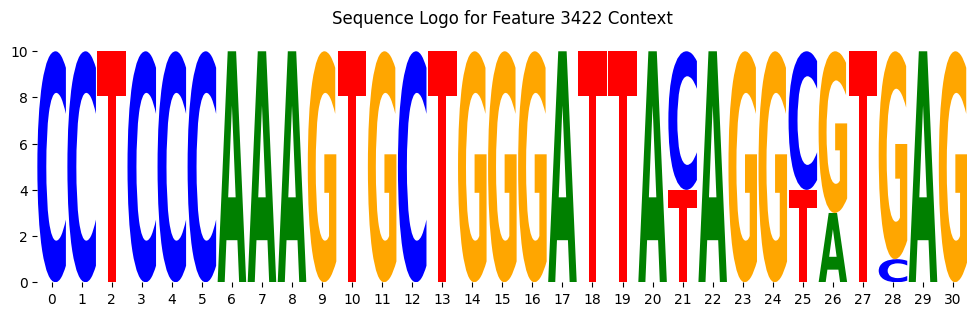

In [15]:
!pip install logomaker

import logomaker
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

# Collect the core sequences (including the conserved prefix)
sequences = [
    "CCTCCCAAAGTGCTGGGATTATAGGCGTGAG",
    "CCTCCCAAAGTGCTGGGATTACAGGTGTGAG",
    "CCTCCCAAAGTGCTGGGATTACAGGCGTGAG",
    "CCTCCCAAAGTGCTGGGATTACAGGCGTGAG",
    "CCTCCCAAAGTGCTGGGATTATAGGTGTGAG",
    "CCTCCCAAAGTGCTGGGATTATAGGCATGAG",
    "CCTCCCAAAGTGCTGGGATTACAGGTGTCAG",
    "CCTCCCAAAGTGCTGGGATTACAGGCATGAG",
    "CCTCCCAAAGTGCTGGGATTATAGGTGTGAG",
    "CCTCCCAAAGTGCTGGGATTACAGGCATGAG"
]

# Create counts matrix
counts_mat = logomaker.alignment_to_matrix(sequences)

# Create Logo object
logo = logomaker.Logo(counts_mat,
                     font_name='Arial',
                     color_scheme='classic',
                     figsize=(12, 3))

# Style using Logo methods
logo.style_spines(visible=False)
logo.style_xticks(rotation=0, fmt='%d', anchor=0)

# Add title
plt.title("Sequence Logo for Feature 3422 Context", pad=20)

plt.show()

In [31]:
import matplotlib.pyplot as plt
import numpy as np
from textwrap import wrap

def plot_highlighted_sequences():
    fig, axs = plt.subplots(10, 1, figsize=(15, 20))
    fig.suptitle('Feature 3422 Activations with Context', fontsize=16)
    
    sequences = [
        "ATTTTTGGTAGAGACAAGGTTTCACCATGTTGGCCAAGCTGGTCTCAAACTCCTGACCTCAGGTGATCCACCCGCCTCGGCCTCCCAAAGTGCTGGGATTATAGGCGTGAGCCACCGCACCCAGCCCACTGAACACTATTTTTTTTTAAATCATAAGATGTTACTGTAAAGCTATATTGCTTCTAACTACTGGAAAACATG",
        "ATTTTTAGTAGAGAAGGAGTTTCACCATGTTGGCCAGGCTGGTCTCAAATTCCTGACCTCAAATGATCTGCCTGCCTCGGCCTCCCAAAGTGCTGGGATTACAGGTGTGAGCCATGGTGCCTGGCCTGACTCTGACTTTTCTTCTTTTTAATGTGGTGAATTATTTAGAGACAGGGTCTTGCTACGTTGCCCAGGTTAGTC",
        # ... add all sequences
    ]
    
    activations = [26.42, 26.33, 25.36, 25.25, 24.74, 23.94, 23.77, 23.55, 23.14, 22.95]
    wrap_length = 100  # characters per line
    line_height = 0.3  # vertical spacing between lines
    
    for idx, (seq, act, ax) in enumerate(zip(sequences, activations, axs)):
        # Find important positions
        conserved_pos = seq.find("CCTCCCAAAGTGCTGGGATT")
        core_start = seq.find("[")
        core_end = seq.find("]")
        
        # Wrap sequence into lines
        wrapped_lines = wrap(seq, wrap_length)
        
        for line_idx, line in enumerate(wrapped_lines):
            y_pos = -line_idx * line_height
            start_pos = line_idx * wrap_length
            
            # Plot each character
            for i, char in enumerate(line):
                abs_pos = start_pos + i  # position in original sequence
                color = 'black'
                alpha = 0.5
                if abs_pos >= conserved_pos and abs_pos < core_start:
                    color = 'darkred'
                    alpha = 1
                elif abs_pos > core_start and abs_pos < core_end:
                    color = 'red'
                    alpha = 1
                ax.text(i, y_pos, char, color=color, alpha=alpha, fontfamily='monospace', fontsize=8)
        
        ax.text(-10, 0, f'Act: {act:.2f}', fontfamily='monospace')
        ax.set_ylim(-len(wrapped_lines) * line_height - 0.5, 0.5)
        ax.axis('off')
    
    plt.subplots_adjust(hspace=1)
    
    # Save figure instead of displaying it
    plt.savefig('feature_3422_sequences.pdf', bbox_inches='tight', dpi=300)
    plt.close()

plot_highlighted_sequences()

In [26]:
# Original sequence we want to test
test_sequence = "ATTTTTGGTAGAGACAAGGTTTCACCATGTTGGCCAAGCTGGTCTCAAACTCCTGACCTCAGGTGATCCACCCGCCTCGGCCTCCCAAAGTGCTGGGATTATAGGCGTGAGCCACCGCACCCAGCCCACTGAACACTATTTTTTTTTAAATCATAAGATGTTACTGTAAAGCTATATTGCTTCTAACTACTGGAAAACATG"

# Function to generate random DNA sequence
def generate_random_sequence(length):
    return np.random.choice([2, 3, 4, 5], size=length)  # 2=A, 3=C, 4=G, 5=T

# Create batch of 16 random sequences
batch_size = 16
seq_length = 8192
sequences = np.array([generate_random_sequence(seq_length) for _ in range(batch_size)])

# Insert our test sequence at random positions in each sequence
test_seq_tokens = tokenize_sequence(test_sequence)
for i in range(batch_size):
    insert_pos = np.random.randint(0, seq_length - len(test_seq_tokens))
    sequences[i, insert_pos:insert_pos + len(test_seq_tokens)] = test_seq_tokens

# Create batch
batch = {
    'x': sequences,
    'segment_ids': np.ones_like(sequences)
}

# Run through model and SAE
batch = jax.device_put(batch, input_shardings(cfg.mesh, cfg.rules))
_, internals = fwd(weights, batch['x'], batch['segment_ids'])
activations = internals['layer_6_activations']

# Get feature activations
activations = activations.reshape(-1, cfg.d_model)
latents = jnp.einsum('bd,df->bf', activations, sae_weights['expand'])
latents = jax.nn.relu(latents)
feature_activations = latents[:, 3422]  # Get activations for feature 3422

# Reshape to get activations for each sequence
feature_activations = feature_activations.reshape(batch_size, -1)

# Create bedGraph file
with open(f'feature_3422_random_test.bedGraph', 'w') as f:
    f.write('track type=bedGraph name="Feature 3422 Random Test" description="Feature activations on random sequences with inserted test sequence"\n')
    for i in range(batch_size):
        chrom = f"seq_{i}"
        for pos in range(seq_length):
            if feature_activations[i, pos] > 0:  # Only write non-zero activations
                f.write(f"{chrom}\t{pos}\t{pos+1}\t{float(feature_activations[i, pos]):.8f}\n")

In [24]:
import requests
import time
import json

def check_sequence_blast(seq):
    """
    Submit a sequence to NCBI BLAST and get results
    """
    # NCBI BLAST API URLs
    put_url = "https://blast.ncbi.nlm.nih.gov/Blast.cgi"
    get_url = "https://blast.ncbi.nlm.nih.gov/Blast.cgi"
    
    # Parameters for the BLAST search
    params = {
        'CMD': 'Put',
        'PROGRAM': 'blastn',
        'DATABASE': 'nr',
        'QUERY': seq,
        'FILTER': 'L',
        'FORMAT_TYPE': 'JSON2',
        'HITLIST_SIZE': 10,
        'ENTREZ_QUERY': 'human[ORGN] AND Alu[TITLE]'
    }
    
    print(f"\nChecking sequence: {seq}")
    
    # Submit the BLAST search
    response = requests.get(put_url, params=params)
    
    if response.status_code == 200:
        # Extract Request ID (RID) from the response text
        for line in response.text.split('\n'):
            if line.startswith('    RID = '):
                rid = line.split(' = ')[1].strip()
                print(f"Request ID: {rid}")
                print(f"Direct link to results:")
                print(f"https://blast.ncbi.nlm.nih.gov/Blast.cgi?CMD=Get&RID={rid}")
                return
    
    print("Error submitting BLAST request")

# Sequences to check
sequences = [
    "AAGTAGCTGGGACTACAGGCG",  # Feature 7845
    "CCCAGCACTTTGGGAGGCCGA",  # Feature 3049
    "CCAGGCTGGAGTACAGTGGTG"   # Feature 4103
]

# Check each sequence
for seq in sequences:
    check_sequence_blast(seq)
    time.sleep(1)  # Add small delay between requests

print("\nAlternatively, you can manually check these sequences at:")
print("1. DFAM database: https://www.dfam.org/search")
print("2. RepeatMasker: https://www.repeatmasker.org/")
print("\nFor each sequence, copy and paste it into these tools to verify if they match known Alu elements.")


Checking sequence: AAGTAGCTGGGACTACAGGCG
Request ID: NFF7NV8A013
Direct link to results:
https://blast.ncbi.nlm.nih.gov/Blast.cgi?CMD=Get&RID=NFF7NV8A013

Checking sequence: CCCAGCACTTTGGGAGGCCGA
Request ID: NFF7PEV4013
Direct link to results:
https://blast.ncbi.nlm.nih.gov/Blast.cgi?CMD=Get&RID=NFF7PEV4013

Checking sequence: CCAGGCTGGAGTACAGTGGTG
Request ID: NFF7SAFM013
Direct link to results:
https://blast.ncbi.nlm.nih.gov/Blast.cgi?CMD=Get&RID=NFF7SAFM013

Alternatively, you can manually check these sequences at:
1. DFAM database: https://www.dfam.org/search
2. RepeatMasker: https://www.repeatmasker.org/

For each sequence, copy and paste it into these tools to verify if they match known Alu elements.


/home/shaemclaughlin/minformer/.venv/lib/python3.10/site-packages/umap/umap_.py:1945: UserWarning: n_jobs value 1 overridden to 1 by setting random_state. Use no seed for parallelism.
  warn(f"n_jobs value {self.n_jobs} overridden to 1 by setting random_state. Use no seed for parallelism.")


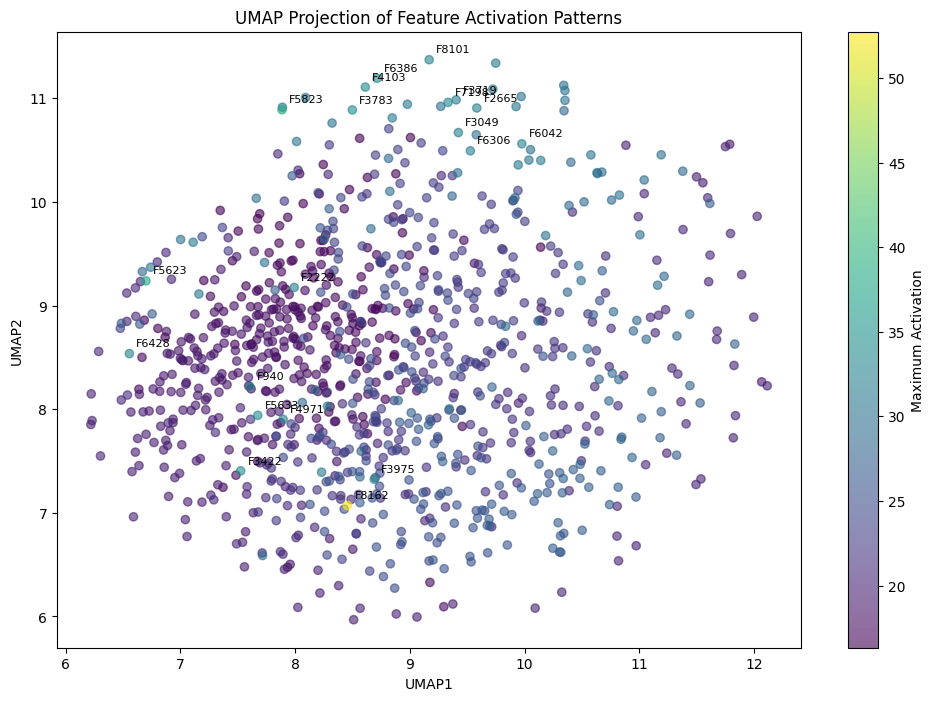


Feature clustering summary:

Number of clusters found: 1
Number of features in clusters: 1000
Number of unclustered features: 0

Largest clusters:
0    1000
Name: count, dtype: int64


In [26]:
import numpy as np
import pandas as pd
import umap
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.preprocessing import StandardScaler

def create_feature_vectors(latents_np, n_top_features=1000):
    """
    Create feature vectors based on activation patterns
    """
    # Get the top n features by maximum activation
    max_activations = np.max(latents_np, axis=0)
    top_feature_indices = np.argsort(max_activations)[-n_top_features:]
    
    # Get activation patterns for top features
    feature_vectors = latents_np[:, top_feature_indices]
    
    # Create a matrix where each row represents a feature's activation pattern
    feature_profiles = feature_vectors.T
    
    return feature_profiles, top_feature_indices

def plot_feature_umap(feature_profiles, feature_indices, max_activations=None, perplexity=30, n_neighbors=15):
    """
    Create UMAP visualization of feature relationships
    """
    # Standardize the features
    scaler = StandardScaler()
    scaled_profiles = scaler.fit_transform(feature_profiles)
    
    # Create UMAP embedding
    reducer = umap.UMAP(n_neighbors=n_neighbors, min_dist=0.1, random_state=42)
    embedding = reducer.fit_transform(scaled_profiles)
    
    # Create figure
    plt.figure(figsize=(12, 8))
    
    # Color by maximum activation if provided
    if max_activations is not None:
        scatter = plt.scatter(embedding[:, 0], embedding[:, 1], 
                            c=max_activations[feature_indices],
                            cmap='viridis', alpha=0.6)
        plt.colorbar(scatter, label='Maximum Activation')
    else:
        plt.scatter(embedding[:, 0], embedding[:, 1], alpha=0.6)
    
    plt.title('UMAP Projection of Feature Activation Patterns')
    plt.xlabel('UMAP1')
    plt.ylabel('UMAP2')
    
    # Add feature indices for some interesting points
    for i, (x, y) in enumerate(embedding):
        if max_activations is not None and max_activations[feature_indices[i]] > np.percentile(max_activations[feature_indices], 98):
            plt.annotate(f'F{feature_indices[i]}', (x, y), xytext=(5, 5), 
                        textcoords='offset points', fontsize=8)
    
    return embedding, feature_indices

# Get activation patterns for features
feature_profiles, top_feature_indices = create_feature_vectors(latents_np)

# Get maximum activation value for each feature
max_activations = np.max(latents_np, axis=0)

# Create UMAP visualization
embedding, indices = plot_feature_umap(feature_profiles, top_feature_indices, max_activations)
plt.show()

# Let's also create a DataFrame with the UMAP coordinates and feature info
umap_df = pd.DataFrame({
    'feature_id': top_feature_indices,
    'umap_1': embedding[:, 0],
    'umap_2': embedding[:, 1],
    'max_activation': max_activations[top_feature_indices]
})

# Save UMAP coordinates
umap_df.to_csv('feature_umap_coords.csv', index=False)

# Print some statistics about clusters
print("\nFeature clustering summary:")
from sklearn.cluster import DBSCAN

# Perform DBSCAN clustering on UMAP coordinates
clustering = DBSCAN(eps=0.5, min_samples=5).fit(embedding)
umap_df['cluster'] = clustering.labels_

print(f"\nNumber of clusters found: {len(set(clustering.labels_)) - (1 if -1 in clustering.labels_ else 0)}")
print(f"Number of features in clusters: {sum(clustering.labels_ != -1)}")
print(f"Number of unclustered features: {sum(clustering.labels_ == -1)}")

# Print info about largest clusters
cluster_sizes = pd.Series(clustering.labels_).value_counts()
print("\nLargest clusters:")
print(cluster_sizes.head())

In [28]:
!pip install networkx biopython python-Levenshtein

/usr/lib/python3.10/pty.py:89: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  pid, fd = os.forkpty()


  Using cached rapidfuzz-3.10.1-cp310-cp310-manylinux_2_17_x86_64.manylinux2014_x86_64.whl.metadata (11 kB)
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.7/1.7 MB 28.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 3.2/3.2 MB 100.5 MB/s eta 0:00:00
Using cached rapidfuzz-3.10.1-cp310-cp310-manylinux_2_17_x86_64.manylinux2014_x86_64.whl (3.1 MB)


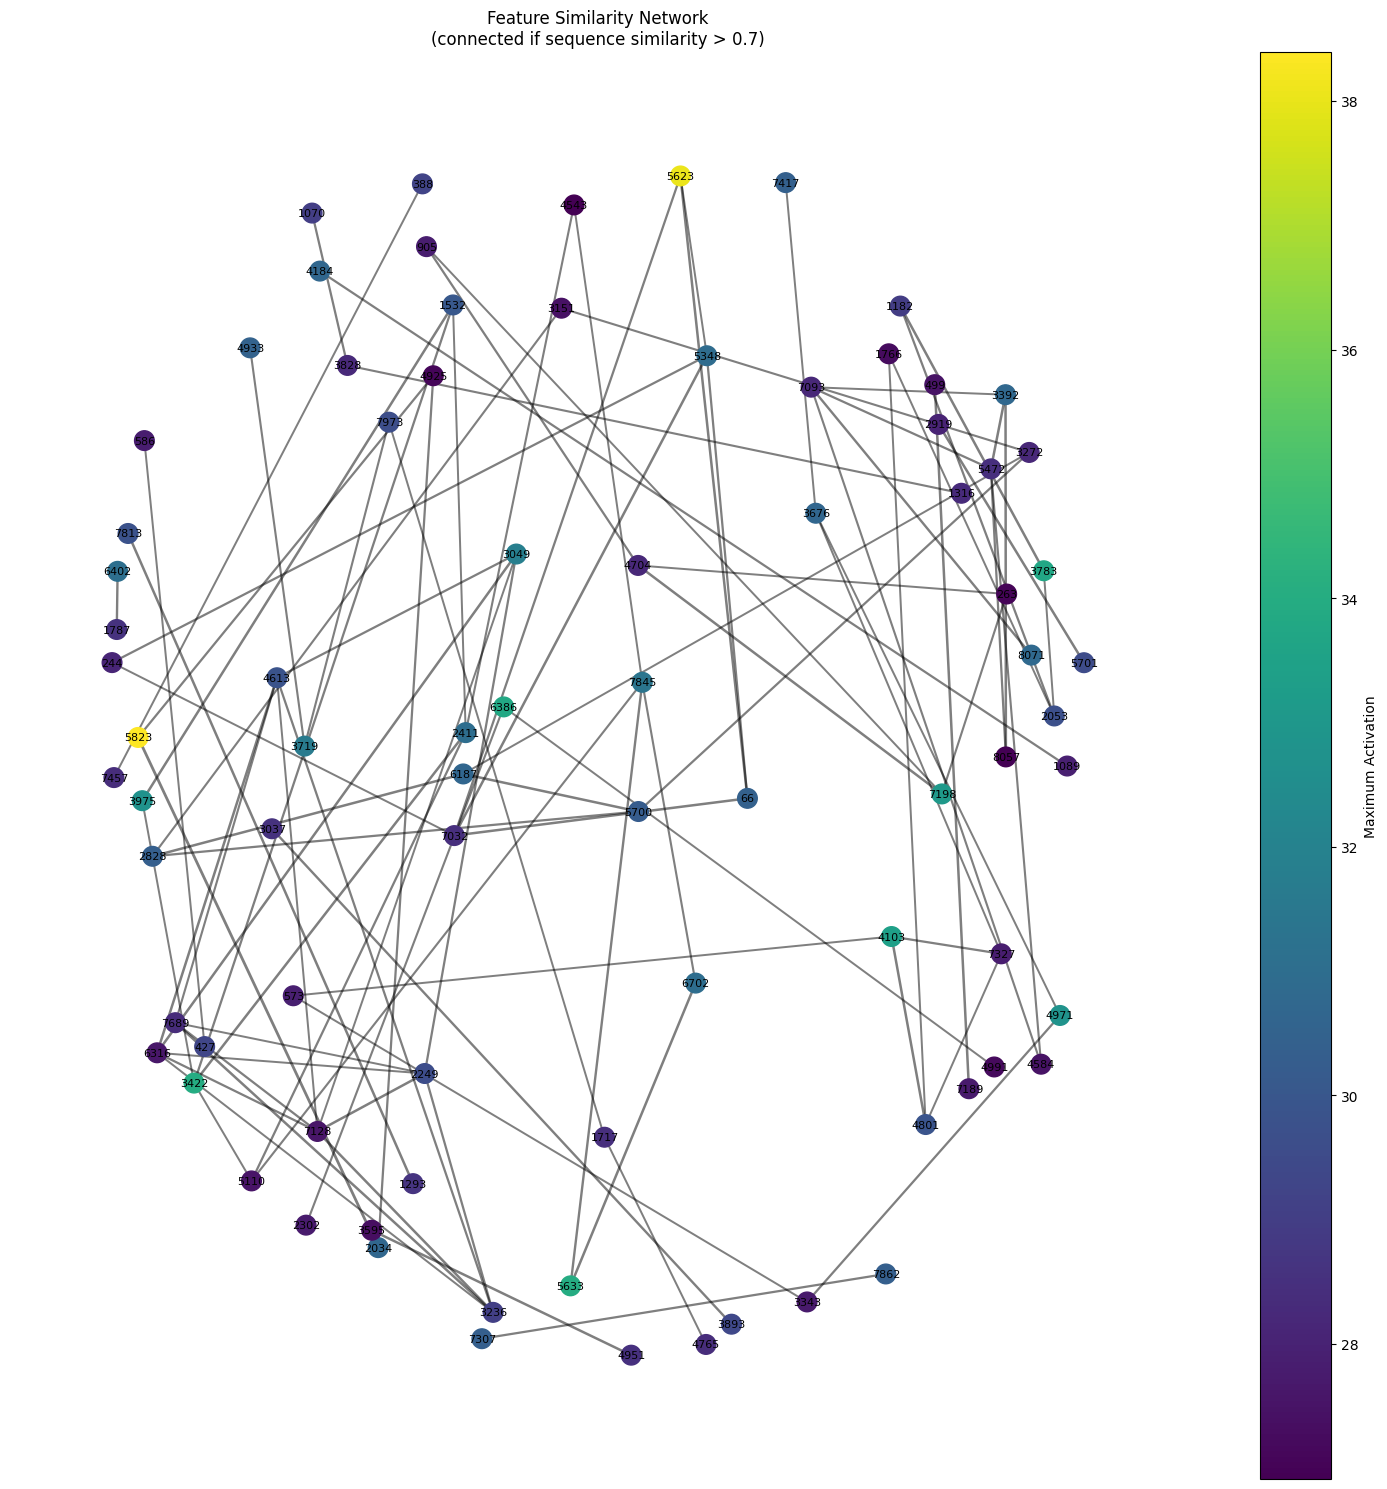


Network Statistics:
Number of nodes (features): 82
Number of edges (similar pairs): 93
Number of connected components: 21

Top 5 largest clusters with their sequences:

Cluster 1 (size: 12)
Feature 573 (activation: 27.87): TCCAGCCTGGGTGACAGAGTG
Feature 1182 (activation: 28.94): CTGCACTCCAGCCTGGGTGAC
Feature 1766 (activation: 27.23): TCACCCAGGCTGGAGTGCAGT

Cluster 2 (size: 9)
Feature 1532 (activation: 30.01): CTGGGATTACAGGTGTGAGCC
Feature 2411 (activation: 30.95): GTGCTGGGATTACAGGTGTGA
Feature 3422 (activation: 33.98): TGCTGGGATTACAGGTGTGAG

Cluster 3 (size: 7)
Feature 2249 (activation: 29.57): CCCAGCTACTCGGGAGGCTGA
Feature 3049 (activation: 31.80): CCCAGCACTTTGGGAGGCCGA
Feature 3236 (activation: 29.03): ATCCCAGCTACTCGGGAGGCT

Cluster 4 (size: 6)
Feature 3392 (activation: 30.73): GCCTGACCAACATGGAGAAAC
Feature 4584 (activation: 27.47): CTGGCCAACATGGCAAAACCC
Feature 5472 (activation: 28.47): CCTGACCAACATGGAGAAACC

Cluster 5 (size: 5)
Feature 66 (activation: 30.45): CTGTAATCCCAGCACTTTGGG


In [31]:
import networkx as nx
import matplotlib.pyplot as plt
import numpy as np
from Levenshtein import distance as lev_distance
from matplotlib.colors import Normalize

def plot_similarity_network(G, min_edge_weight=0.7):
    """Plot the similarity network with fixed colorbar"""
    # Create figure and axis
    fig, ax = plt.subplots(figsize=(15, 15))
    
    # Remove edges below threshold
    G_filtered = G.copy()
    edges_to_remove = [(u, v) for u, v, d in G_filtered.edges(data=True) 
                      if d['weight'] < min_edge_weight]
    G_filtered.remove_edges_from(edges_to_remove)
    
    # Remove isolated nodes
    G_filtered.remove_nodes_from(list(nx.isolates(G_filtered)))
    
    # Get node positions using force-directed layout
    pos = nx.spring_layout(G_filtered, k=1, iterations=50)
    
    # Get node colors based on activation values
    node_colors = [G_filtered.nodes[node]['activation'] for node in G_filtered.nodes()]
    
    # Create a normalization for the colormap
    norm = Normalize(vmin=min(node_colors), vmax=max(node_colors))
    colors = plt.cm.viridis(norm(node_colors))
    
    # Draw the network
    nodes = nx.draw_networkx_nodes(G_filtered, pos, 
                                 node_color=colors, 
                                 node_size=200,
                                 ax=ax)
    
    # Draw edges with width based on similarity
    edge_weights = [G_filtered[u][v]['weight'] for u, v in G_filtered.edges()]
    nx.draw_networkx_edges(G_filtered, pos, 
                          width=[w * 2 for w in edge_weights],
                          alpha=0.5,
                          ax=ax)
    
    # Add labels
    nx.draw_networkx_labels(G_filtered, pos, font_size=8)
    
    plt.title("Feature Similarity Network\n(connected if sequence similarity > {})".format(min_edge_weight))
    
    # Add colorbar properly
    sm = plt.cm.ScalarMappable(cmap=plt.cm.viridis, norm=norm)
    plt.colorbar(sm, ax=ax, label="Maximum Activation")
    
    plt.axis('off')
    plt.tight_layout()
    
    return G_filtered

# Create and plot network
G = create_similarity_network(df, similarity_threshold=0.7, min_activation=25)
G_filtered = plot_similarity_network(G, min_edge_weight=0.7)
plt.show()

# Print network analysis
print("\nNetwork Statistics:")
print(f"Number of nodes (features): {G_filtered.number_of_nodes()}")
print(f"Number of edges (similar pairs): {G_filtered.number_of_edges()}")
print(f"Number of connected components: {nx.number_connected_components(G_filtered)}")

# Analyze the clusters
components = list(nx.connected_components(G_filtered))
print("\nTop 5 largest clusters with their sequences:")
for i, component in enumerate(sorted(components, key=len, reverse=True)[:5]):
    print(f"\nCluster {i+1} (size: {len(component)})")
    # Get sequences for this cluster
    cluster_seqs = []
    for feature in sorted(component)[:3]:  # Show first 3 features
        sequence = G_filtered.nodes[feature]['sequence']
        activation = G_filtered.nodes[feature]['activation']
        cluster_seqs.append((feature, activation, sequence))
    
    # Print the sequences
    for feature, activation, seq in cluster_seqs:
        print(f"Feature {feature} (activation: {activation:.2f}): {seq}")

In [ ]:
jax.tree.map(jnp.shape, internals)